# How to PLD with TESS, pt II --- Accounting for dilution
------
An iPython tutorial --- by **Néstor Espinoza (nespinoza@stsci.edu)**

In the previous notebook, we performed PLD directly on the data and it worked fine. However, we didn't account for the fact that there were diluting sources on the apertures we were using to extract the data. Here, we correct for that before performing the PLD fits; this will allow us to get diluted-corrected lightcurves on which to perform our analyses.

In this example, we play with the data of WASP-6b, whose dilution is very significant, as we will see below.

## 1. Introduction
First things first, again, let's import some libraries:

In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import requests
import urllib
import re

import seaborn as sns
from astropy.io import fits
import lightkurve as lk

import juliet

Note we are importing `lightkurve` now, as we will use their tools to extract all the information we need for both, correcting for dilution and for performing PLD.

## 2. Light curve extraction and header information

Let's first extract the **target-pixel file** data for WASP-6b (TIC ID: 204376737) using `lightkurve`:

In [2]:
search_result = lk.search_targetpixelfile('TIC 204376737')

In [3]:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 02,2018,SPOC,120,204376737,0.0
1,TESS Sector 02,2018,TESS-SPOC,1800,204376737,0.0
2,TESS Sector 29,2020,SPOC,20,204376737,0.0
3,TESS Sector 29,2020,SPOC,120,204376737,0.0
4,TESS Sector 29,2020,TESS-SPOC,600,204376737,0.0


All right. So for this test, let's use the Sector 29 data; in particular, let's get the 120-second (2-minute) cadence data:

In [4]:
tpf_file = search_result[3].download(quality_bitmask='default')

### 2.1 Headers

The `tpf_file` object contains a ton of information. Aside from the actual target pixel files, which are the ones we want to use to extract the lightcurves, there is one important field in the headers that is of a ton of use to us if we wanted to correct for dilution: the `CROWDSAP` value. This can be found in the `tpf_file` headers as follows:

In [5]:
CROWDSAP = tpf_file.hdu[1].header['CROWDSAP']
print('CROWDSAP value:',CROWDSAP)

CROWDSAP value: 0.99814135


This value represents the **_ratio of the target flux to the total flux in the optimal aperture_** in the TESS bandpass. Mathematicaly, this is:

$\textrm{CROWDSAP} = \frac{F_T}{\sum{F_i}}$

where $F_T$ is the flux of the target in the aperture, and $F_i$ is the flux of all the sources (including the target) in the aperture. This is an important number that we will be using below to correct the fluxes for dilution.

### 2.2 Extracting lightcurves

Let's extract the times and the fluxes from the TPFs:

In [6]:
all_times = tpf_file.time.value + 2457000
tpfs = tpf_file.flux
tpfs_err = tpf_file.flux_err

The `tpfs` are the "pixel stamps" --- we need a mask to extract the lightcurves from them! Luckily, the "optimal mask" (the "pipeline" mask) is available in the `tpf_file`, too:

In [7]:
mask = tpf_file.pipeline_mask

In [8]:
print(mask)

[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False  True False False False False]
 [False False False False False  True  True  True False False False]
 [False False False False  True  True  True  True False False False]
 [False False False False False  True  True False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]


Let's use this binary mask to extract both, the lightcurve of each pixel and the lightcurve of all the pixels in the mask added up:

In [9]:
nframes = tpfs.shape[0]
npixels = np.sum(mask)

# Array that will save the pixel-level lightcurves:
pixel_lightcurves = np.zeros([nframes, npixels])

# Array that will save the added lightcurves and errors:
lightcurve = np.zeros(nframes)
errors = np.zeros(nframes)

# Extract rows and columns of each pixel:
rows, columns = np.where(mask)

# Iterate through each frame:
for i in range(nframes):
    
    # Get lightcurve:
    lightcurve[i] = np.sum( tpfs[i, :, :].value * mask )
    errors[i] = np.sqrt( np.sum( tpfs_err[i, :, :].value**2 * mask ) )
    
    # Get pixel-level lightcurves:
    for j in range(npixels):
        
        pixel_lightcurves[i, j] = tpfs[i, rows[j], columns[j]].value
    

Text(0.5, 0, 'Time (BJD - 2459088)')

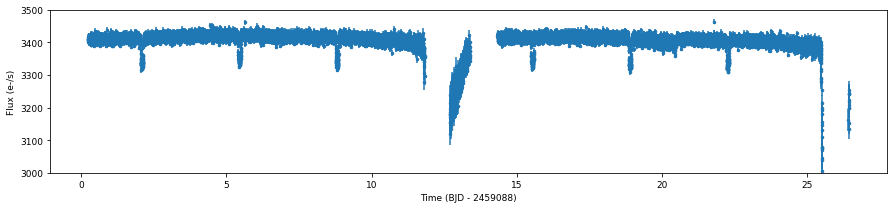

In [10]:
plt.figure(figsize=(15,3))
plt.errorbar(all_times-int(all_times[0]), lightcurve, errors, fmt = '.')
plt.ylim(3000,3500)
plt.ylabel('Flux (e-/s)')
plt.xlabel('Time (BJD - '+str(int(all_times[0]))+')')

All right, great! The transits are there. Let's clean the lightcurve a little bit --- let's only save data in the plot above from 0 to 25, and fluxes only within 3300 to 3500. Let's also eliminat `nan` values:

In [12]:
cut1 = (all_times-int(all_times[0]) > 0) & (all_times-int(all_times[0]) < 25)
cut2 = ~np.isnan(lightcurve)
cut3 = (lightcurve > 3300) & (lightcurve < 3500)

idx_good = np.where((cut1 & cut2 & cut3))

In [13]:
all_times = all_times[idx_good]
lightcurve = lightcurve[idx_good]
errors = errors[idx_good]
pixel_lightcurves = pixel_lightcurves[idx_good, :]

Let's plot again:

Text(0.5, 0, 'Time (BJD - 2459088)')

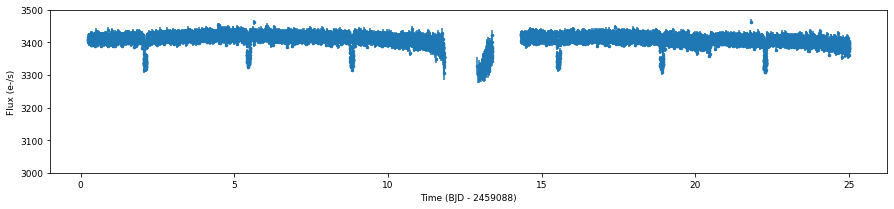

In [14]:
plt.figure(figsize=(15,3))
plt.errorbar(all_times-int(all_times[0]), lightcurve, errors, fmt = '.')
plt.ylim(3000,3500)
plt.ylabel('Flux (e-/s)')
plt.xlabel('Time (BJD - '+str(int(all_times[0]))+')')

That looks much better! Let's get to fitting.

## 3. Lightcurve fitting

### 3.1 Performing 1st order PLD

So, we know the drill; let's get the PLD regressors via PCA for this dataset:

In [15]:
def get_mad_sigma(x):
    """
    Estimate the robust version of the standard deviation (sigma) using the Median Absolute Deviation (MAD).
    See: https://en.wikipedia.org/wiki/Median_absolute_deviation
    """
    return np.median(np.abs(x-np.median(x)))*1.4826

def standarize_data(input_data):
    """
    Standarize the dataset
    """
    output_data = np.copy(input_data)
    averages = np.median(input_data,axis=1)
    for i in range(len(averages)):
        sigma = get_mad_sigma(output_data[i,:])
        output_data[i,:] = output_data[i,:] - averages[i]
        output_data[i,:] = output_data[i,:]/sigma
    return output_data

def classic_PCA(Input_Data, standarize = True):
    """  
    classic_PCA function
    Description
    This function performs the classic Principal Component Analysis on a given dataset.
    """
    if standarize:
        Data = standarize_data(Input_Data)
    else:
        Data = np.copy(Input_Data)
    eigenvectors_cols,eigenvalues,eigenvectors_rows = np.linalg.svd(np.cov(Data))
    idx = eigenvalues.argsort()
    eigenvalues = eigenvalues[idx[::-1]]
    eigenvectors_cols = eigenvectors_cols[:,idx[::-1]]
    eigenvectors_rows = eigenvectors_rows[idx[::-1],:]
    # Return: V matrix, eigenvalues and the principal components.
    return eigenvectors_rows,eigenvalues,np.dot(eigenvectors_rows,Data)

In [16]:
# Get normalized pixel-level lightcurves:
Phat = np.zeros([pixel_lightcurves.shape[1], pixel_lightcurves.shape[2]])
Psum = np.sum(pixel_lightcurves[0,:,:],axis=1)
for i in range(Phat.shape[0]):
    Phat[i,:] = pixel_lightcurves[0,i,:]/Psum[i]
    
# Apply PCA:
V, eigenvalues, PCA = classic_PCA(Phat.T)

# Get only 5 first components as regressors:
X = PCA[:5,:]

### 3.2 Performing lightcurve fit correcting dilution _before_ the fit

Let's perform the lightcurve fit. We do it in two stages; first fit the out-of-transit data with PLD + GP; then in-transit data with all together. Let's get functions to extract transit parameter data:

In [17]:
def get_canonical_name(target_name):
    '''Get ExoMAST prefered name for exoplanet.
        Parameters
        ----------
        target_name : string
            The name of the target transit.
        Returns
        -------
        canonical_name : string
    '''

    target_url = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/identifiers/"

    # Create params dict for url parsing. Easier than trying to format yourself.
    params = {"name": target_name}

    r = requests.get(target_url, params=params)
    planetnames = r.json()
    canonical_name = planetnames['canonicalName']

    return canonical_name


def build_target_url(target_name):
    '''Build restful api url based on target name.
    Parameters
        ----------
        target_name : string
            The name of the target transit.
        Returns
        -------
        target_url : string
    '''
    # Encode the target name string.
    encode_target_name = urllib.parse.quote(target_name, encoding='utf-8')
    target_url = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/{}/properties/".format(encode_target_name)

    return target_url

def get_target_data(target_name):
    """
    Send request to exomast restful api for target information.
    Parameters
    ----------
    target_name : string
        The name of the target transit
    Returns
    -------
    target_data: json:
        json object with target data.
    """

    canonical_name = get_canonical_name(target_name)

    target_url = build_target_url(canonical_name)

    r = requests.get(target_url)

    if r.status_code == 200:
        target_data = r.json()
    else:
        print('Whoops, no data for this target!')

    # Some targets have multiple catalogs
    # nexsci is the first choice.
    if len(target_data) > 1:
        # Get catalog names from exomast and make then the keys of a dictionary
        # and the values are its position in the json object.
        catalog_dict = {data['catalog_name']: index for index, data in enumerate(target_data)}

        # Parse based on catalog accuracy.
        if 'nexsci' in list(catalog_dict.keys()):
            target_data = target_data[catalog_dict['nexsci']]
        elif 'exoplanets.org' in list(catalog_dict.keys()):
            target_data = target_data[catalog_dict['exoplanets.org']]
        else:
            target_data = target_data[0]
    else:
        target_data = target_data[0]

    # Strip spaces and non numeric or alphabetic characters and combine.
    url = 'https://exo.mast.stsci.edu/exomast_planet.html?planet={}'.format(re.sub(r'\W+', '', canonical_name))

    return target_data, url

In [18]:
data, url = get_target_data('WASP-6b')

In [19]:
P, t0, transit_duration = data['orbital_period'], data['transit_time']+2400000.5,\
                          data['transit_duration'] * 2

Now, let's correct the data for any dilutions before doing the fit. To this end, let's assume the median counts of the raw lightcurve are a good measure of the real flux in the aperture of the TESS bandpass:

In [20]:
aperture_flux = np.median(lightcurve)

Now, this flux is the sum of the flux from the target _and_ any nearby stars. How many counts we have to substract to it in order for it to measure only the flux of the target star, WASP-6? Well, remember we had the `CROWDSAP` value above? We can use that to figure that out. Remember that

$\textrm{CROWDSAP} = F_T/\sum F_i$.

The value of `aperture_flux` above is our best estimate for $\sum F_i$. This means that: 

$F_T = \textrm{CROWDSAP} \times \sum F_i \approx \textrm{CROWDSAP} \times \textrm{aperture_flux}$.

Replacing this last equation on the first one, we see that:

$\sum F_{i \neq T} = \sum F_i (1- \textrm{CROWDSAP}) \approx \textrm{aperture_flux} (1- \textrm{CROWDSAP})$,

where $\sum F_{i \neq T}$ is the sum of the flux of all the sources _but_ WASP-6. If we remove $\sum F_{i \neq T}$ to $\sum F_i$ we get $F_T$ --- the flux of WASP-6. Let's do this empirically:

In [21]:
corrected_lightcurve = lightcurve - aperture_flux * (1 - CROWDSAP)

Now, this creates a simple offset in the flux time-series. However, the change as a function of time comes when we plot the _normalized_ lightcurves:

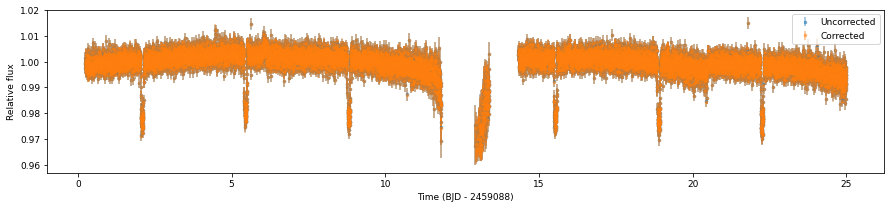

In [22]:
plt.figure(figsize=(15,3))
plt.errorbar(all_times-int(all_times[0]), lightcurve / np.median(lightcurve), \
             errors / np.median(lightcurve), fmt = '.',alpha=0.5, label = 'Uncorrected')
plt.errorbar(all_times-int(all_times[0]), corrected_lightcurve / np.median(corrected_lightcurve), \
             errors / np.median(corrected_lightcurve), fmt = '.',alpha=0.5, label = 'Corrected')
plt.ylabel('Relative flux')
plt.xlabel('Time (BJD - '+str(int(all_times[0]))+')')
plt.legend()

They look almost the same ---  let's look at the difference between the lightcurves:

Text(0.5, 0, 'Time (BJD - 2459088)')

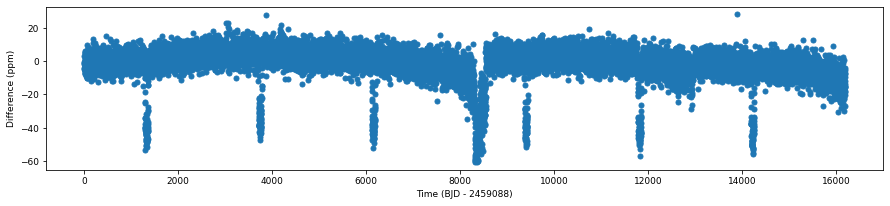

In [23]:
plt.figure(figsize=(15,3))

plt.plot( ((corrected_lightcurve / np.median(corrected_lightcurve)) - \
          (lightcurve / np.median(lightcurve)))*1e6,'o')
plt.ylabel('Difference (ppm)')
plt.xlabel('Time (BJD - '+str(int(all_times[0]))+')')

All right, the dilution is small --- as expected from the `CROWDSAP` value. Only ~50 ppm variations can be blamed to dilution in this case!

**Let's run a PLD + GP fit on this corrected lightcurve**. 

First, we get the out-of-transit data:

<ErrorbarContainer object of 3 artists>

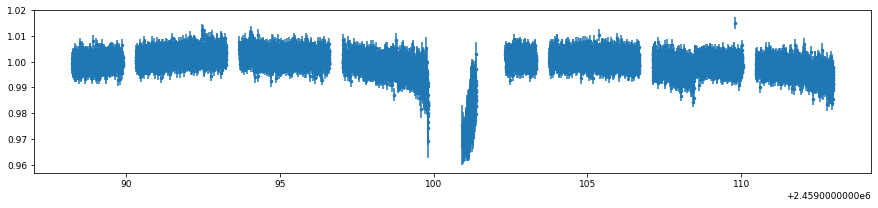

In [24]:
phases = juliet.utils.get_phases(all_times, P, t0)
idx_oot = np.where(np.abs(phases) > (transit_duration/P))[0]

t_oot, f_oot, ferr_oot = all_times[idx_oot], \
                         corrected_lightcurve[idx_oot] / np.median(corrected_lightcurve[idx_oot]), \
                         errors[idx_oot] / np.median(corrected_lightcurve[idx_oot])

plt.figure(figsize=(15,3))
plt.errorbar(t_oot, f_oot, ferr_oot, fmt = '.')

All right; let's define the priors for the fit:

In [25]:
#                                                             These are for the GP
# Name of the parameters to be fit:                      v----------------------------v
params = ['mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS','GP_sigma_TESS','GP_rho_TESS',\
          'theta0_TESS', 'theta1_TESS', 'theta2_TESS', 'theta3_TESS', 'theta4_TESS']
#         ^-----------------------------------------------------------------------^
#                              These are for the PCA components

# Distributions:
dists = ['fixed', 'normal', 'loguniform', 'loguniform', 'loguniform',\
         'uniform', 'uniform', 'uniform', 'uniform', 'uniform']

# Hyperparameters
hyperps = [1.0, [0.,0.1], [0.1, 1000.],[1e-6,1e3], [1e-6, 1e3],\
          [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.], [-1.,1.]]

# Join priors:
priors = juliet.generate_priors(params,dists,hyperps)

Data in juliet-friendly format:

In [26]:
times, fluxes, fluxes_error, linear_regressors, GP_regressors = {}, {}, {}, {}, {}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t_oot, f_oot, ferr_oot

# Note linear regressors match the out-of-transit data:
linear_regressors['TESS'] = X[:,idx_oot].T

# Same for the GP regressor:
GP_regressors['TESS'] = t_oot

Load and fit!

In [27]:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                                yerr_lc = fluxes_error, GP_regressors_lc = GP_regressors,\
                                linear_regressors_lc = linear_regressors, out_folder = 'juliet_oot_results')

results = dataset.fit(use_dynesty = True, dynamic = True, dynesty_nthreads=4)

Detected dynamic_dynesty sampler output files --- extracting from juliet_oot_results/_dynesty_DNS_posteriors.pkl


All right, so now we have the out-of-transit data fit. Let's take a look at how the fits looks:

Text(0, 0.5, 'Relative flux')

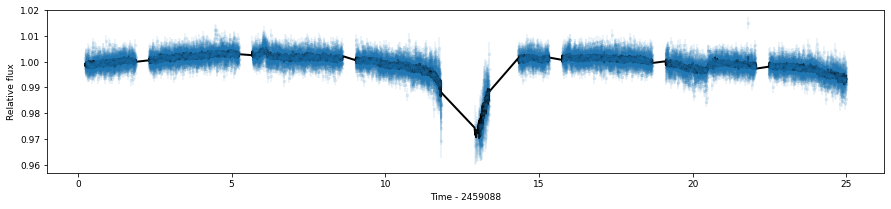

In [28]:
model = results.lc.evaluate('TESS')

plt.figure(figsize=(15,3))
plt.errorbar(t_oot - int(t_oot[0]), f_oot, ferr_oot, fmt = '.', alpha = 0.1)
plt.plot(t_oot - int(t_oot[0]), model, 'k', lw = 2)

plt.xlabel('Time - '+str(int(t_oot[0])))
plt.ylabel('Relative flux')

A close-up:

(0.9925, 1.0075)

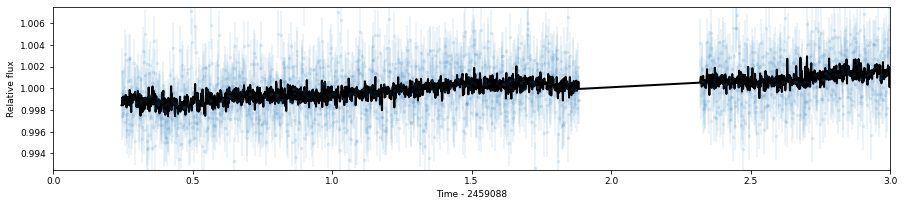

In [29]:
plt.figure(figsize=(15,3))
plt.errorbar(t_oot - int(t_oot[0]), f_oot, ferr_oot, fmt = '.', alpha = 0.1)
plt.plot(t_oot - int(t_oot[0]), model, 'k', lw = 2)

plt.xlabel('Time - '+str(int(t_oot[0])))
plt.ylabel('Relative flux')
plt.xlim(0,3)
plt.ylim(0.9925,1.0075)

All right, that looks nice. Let's look at the `posteriors.dat` output file:

In [30]:
cat juliet_oot_results/posteriors.dat

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
mflux_TESS         	 	 0.0025292054 	 	 0.0022439951 	 	 0.0022122670
sigma_w_TESS       	 	 890.4983951973 	 	 38.3349251505 	 	 40.4119019036
GP_sigma_TESS      	 	 0.0062928694 	 	 0.0017843156 	 	 0.0011870172
GP_rho_TESS        	 	 1.4291660708 	 	 0.3419834515 	 	 0.2425136804
theta0_TESS        	 	 0.0005906501 	 	 0.0001170102 	 	 0.0001156160
theta1_TESS        	 	 0.0002375630 	 	 0.0000590877 	 	 0.0000589296
theta2_TESS        	 	 0.0002979797 	 	 0.0000908488 	 	 0.0000905201
theta3_TESS        	 	 0.0040343579 	 	 0.0001754410 	 	 0.0001765945
theta4_TESS        	 	 0.0010180636 	 	 0.0001448391 	 	 0.0001415250


There seems to be some significant component from the PLD coefficients! Let's plot the residuals from our PLD + GP fit:

Text(0, 0.5, 'Residuals (ppm)')

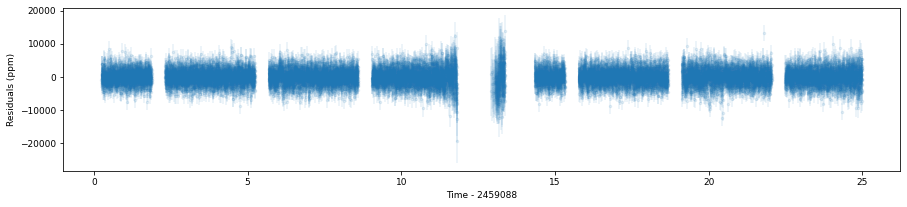

In [31]:
plt.figure(figsize=(15,3))

sigma_w = np.median(results.posteriors['posterior_samples']['sigma_w_TESS']) * 1e-6

new_errors = np.sqrt( ferr_oot**2 + sigma_w**2 )
plt.errorbar(t_oot - int(t_oot[0]), (f_oot - model) * 1e6, new_errors * 1e6, fmt = '.', alpha = 0.1)

plt.xlabel('Time - '+str(int(t_oot[0])))
plt.ylabel('Residuals (ppm)')

A close-up:

(-10000.0, 10000.0)

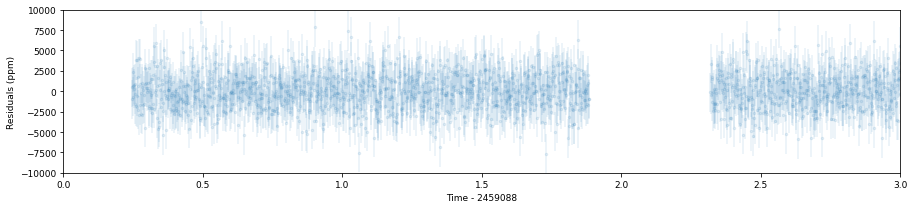

In [32]:
plt.figure(figsize=(15,3))
plt.errorbar(t_oot - int(t_oot[0]), (f_oot - model) * 1e6, new_errors * 1e6, fmt = '.', alpha = 0.1)

plt.xlabel('Time - '+str(int(t_oot[0])))
plt.ylabel('Residuals (ppm)')
plt.xlim(0,3)
plt.ylim(-10000,10000)

That looks pretty nice! Errorbars follow the variations of the data. All right, **let's now fit the in-transit data**. First, priors --- we use the posteriors from the out-of-transit data for the instrumental/systematic noise parameters:

In [33]:
#                                                             These are for the GP
# Name of the parameters to be fit:                      v----------------------------v
params = ['mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS','GP_sigma_TESS','GP_rho_TESS',\
          'theta0_TESS', 'theta1_TESS', 'theta2_TESS', 'theta3_TESS', 'theta4_TESS',\
          'P_p1', 't0_p1', 'rho', 'p_p1', 'b_p1','ecc_p1','omega_p1',\
          'q1_TESS', 'q2_TESS']

# Distributions:
dists = ['fixed', 'normal', 'normal', 'normal', 'normal',\
         'normal', 'normal', 'normal', 'normal', 'normal',\
         'normal', 'normal', 'loguniform', 'uniform', 'uniform', 'fixed', 'fixed',\
         'uniform', 'uniform']

# Hyperparameters
hyperps = [1.0, [0.0025,0.0022], [890, 39], [0.00629,0.0017], [1.43, 0.34],\
          [0.00059,0.00011], [0.00023,0.000059], [0.00029,0.000090], [0.0040,0.00017], [0.0010,0.00014], \
          [3.36,0.1], [2455278.7, 0.1], [100,10000], [0., 1.], [0., 1.], 0., 90.,\
          [0., 1.], [0., 1.]]

# Join priors:
priors = juliet.generate_priors(params,dists,hyperps)

Get the in-transit data:

<ErrorbarContainer object of 3 artists>

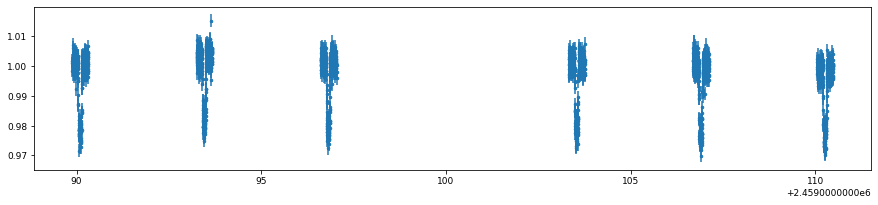

In [34]:
idx_it = np.where(np.abs(phases) <= (transit_duration/P))[0]

t_it, f_it, ferr_it = all_times[idx_it], \
                      corrected_lightcurve[idx_it] / np.median(corrected_lightcurve[idx_it]), \
                      errors[idx_it] / np.median(corrected_lightcurve[idx_it])

plt.figure(figsize=(15,3))
plt.errorbar(t_it, f_it, ferr_it, fmt = '.')

All right, we did a good job! Let's now fit this:

In [35]:
times, fluxes, fluxes_error, linear_regressors, GP_regressors = {}, {}, {}, {}, {}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t_it, f_it, ferr_it

# Note linear regressors match the out-of-transit data:
linear_regressors['TESS'] = X[:,idx_it].T

# Same for the GP regressor:
GP_regressors['TESS'] = t_it

In [36]:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                                yerr_lc = fluxes_error, GP_regressors_lc = GP_regressors,\
                                linear_regressors_lc = linear_regressors, out_folder = 'juliet_it_results')

results = dataset.fit(use_dynesty = True, dynamic = True, dynesty_nthreads=4)

48987it [38:59, 20.94it/s, batch: 6 | bound: 698 | nc: 25 | ncall: 1333793 | eff(%):  3.673 | loglstar: 8600.750 < 8610.329 < 8606.608 | logz: 8546.510 +/-  0.479 | stop:  0.945]        


And let's see how we did:

Text(0, 0.5, 'Relative flux')

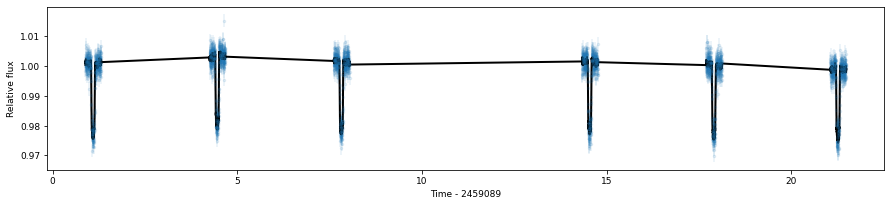

In [38]:
model = results.lc.evaluate('TESS')

plt.figure(figsize=(15,3))
plt.errorbar(t_it - int(t_it[0]), f_it, ferr_it, fmt = '.', alpha = 0.1)
plt.plot(t_it - int(t_it[0]), model, 'k', lw = 2)

plt.xlabel('Time - '+str(int(t_it[0])))
plt.ylabel('Relative flux')

Let's plot the phased lightcurve; to this end, let's get the best-fit period:

In [39]:
cat juliet_it_results/posteriors.dat

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
mflux_TESS         	 	 -0.0005109742 	 	 0.0003412856 	 	 0.0003251233
sigma_w_TESS       	 	 914.2385869999 	 	 25.7516294767 	 	 44.9059391841
GP_sigma_TESS      	 	 0.0012175897 	 	 0.0002011722 	 	 0.0001633043
GP_rho_TESS        	 	 0.1726784723 	 	 0.0159101456 	 	 0.0148518426
theta0_TESS        	 	 0.0005505523 	 	 0.0000678212 	 	 0.0000678159
theta1_TESS        	 	 0.0002451932 	 	 0.0000570959 	 	 0.0000493383
theta2_TESS        	 	 0.0003523008 	 	 0.0000527121 	 	 0.0000511348
theta3_TESS        	 	 0.0039319375 	 	 0.0001274660 	 	 0.0001120831
theta4_TESS        	 	 0.0009634100 	 	 0.0001023045 	 	 0.0000960724
P_p1               	 	 3.3610846248 	 	 0.0000203123 	 	 0.0000308821
a_p1               	 	 10.6681373632 	 	 0.3112126097 	 	 0.2629642176
t0_p1              	 	 2455278.6230456950 	 	 0.0350738009 	 	 0.0231354786
rho                	 	 2033.0848605113 	 	 183.2317712020 	 	 146.6707456557

In [41]:
phases = juliet.utils.get_phases(t_it, 3.3610846248, 2455278.6230456950)

model, comps = results.lc.evaluate('TESS', return_components = True)

(-3.0, 3.0)

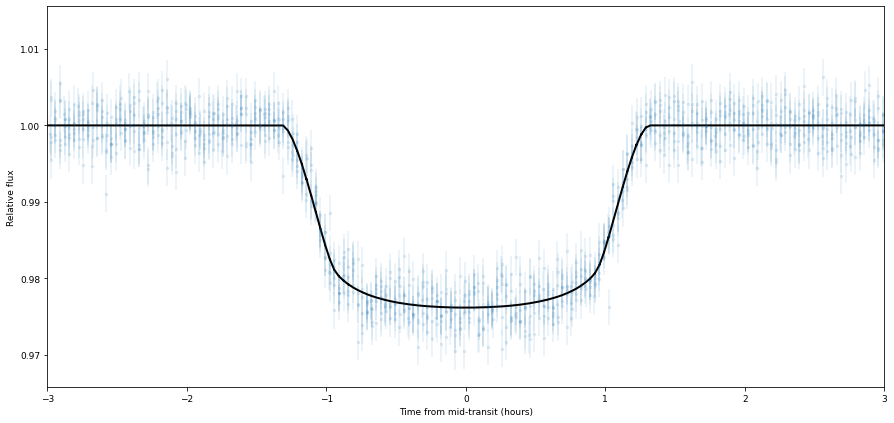

In [49]:
# Get component of the model that holds only the GP and the linear model:
gp_and_pld = model - comps['transit']
# Get updated sigma_w component:
sigma_w = np.median(results.posteriors['posterior_samples']['sigma_w_TESS']) * 1e-6
new_errors = np.sqrt( ferr_it**2 + sigma_w**2 )

# Plot phased systematics-corrected data, along with transit model:
idx = np.argsort(phases)
plt.figure(figsize=(15,7))
plt.errorbar(phases * 3.3610846248*24, f_it - gp_and_pld, new_errors, fmt = '.', alpha = 0.1)
plt.plot(phases[idx] * 3.3610846248*24, comps['transit'][idx], 'k', lw = 2)

plt.xlabel('Time from mid-transit (hours)')
plt.ylabel('Relative flux')
plt.xlim(-3,3)

That looks pretty nice!

### 3.3 Performing lightcurve fit correcting dilution _together with_ the fit

Turns out, with `juliet` you don't need to "fix" or "correct" the lightcurve in order to account for dilution --- you can do it _jointly_ in the fit directly through the `mdilution` parameter. Simply fix or allow that parameter to be free around the `CROWDSAP` value, and that's it. Let's do a fit on the _original_ normalized data, fixing the `mdilution_TESS` parameter to the value of `CROWDSAP`:

In [50]:
#                                                             These are for the GP
# Name of the parameters to be fit:                      v----------------------------v
params = ['mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS','GP_sigma_TESS','GP_rho_TESS',\
          'theta0_TESS', 'theta1_TESS', 'theta2_TESS', 'theta3_TESS', 'theta4_TESS',\
          'P_p1', 't0_p1', 'rho', 'p_p1', 'b_p1','ecc_p1','omega_p1',\
          'q1_TESS', 'q2_TESS']

# Distributions:
dists = ['fixed', 'normal', 'normal', 'normal', 'normal',\
         'normal', 'normal', 'normal', 'normal', 'normal',\
         'normal', 'normal', 'loguniform', 'uniform', 'uniform', 'fixed', 'fixed',\
         'uniform', 'uniform']

# Hyperparameters
hyperps = [CROWDSAP, [0.0025,0.0022], [890, 39], [0.00629,0.0017], [1.43, 0.34],\
          [0.00059,0.00011], [0.00023,0.000059], [0.00029,0.000090], [0.0040,0.00017], [0.0010,0.00014], \
          [3.36,0.1], [2455278.7, 0.1], [100,10000], [0., 1.], [0., 1.], 0., 90.,\
          [0., 1.], [0., 1.]]

# Join priors:
priors = juliet.generate_priors(params,dists,hyperps)

<ErrorbarContainer object of 3 artists>

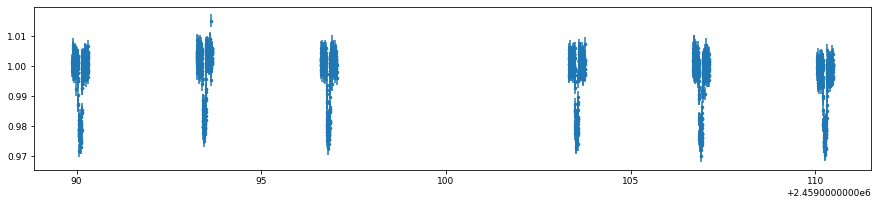

In [51]:
t_it, f_it, ferr_it = all_times[idx_it], \
                      lightcurve[idx_it] / np.median(lightcurve[idx_it]), \
                      errors[idx_it] / np.median(lightcurve[idx_it])

plt.figure(figsize=(15,3))
plt.errorbar(t_it, f_it, ferr_it, fmt = '.')

In [52]:
times, fluxes, fluxes_error, linear_regressors, GP_regressors = {}, {}, {}, {}, {}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t_it, f_it, ferr_it

# Note linear regressors match the out-of-transit data:
linear_regressors['TESS'] = X[:,idx_it].T

# Same for the GP regressor:
GP_regressors['TESS'] = t_it

In [ ]:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes,\
                                yerr_lc = fluxes_error, GP_regressors_lc = GP_regressors,\
                                linear_regressors_lc = linear_regressors, out_folder = 'juliet_it_dilution_results')

results = dataset.fit(use_dynesty = True, dynamic = True, dynesty_nthreads=4)

1622it [00:51, 10.88it/s, batch: 0 | bound: 0 | nc: 47 | ncall: 13715 | eff(%): 11.410 | loglstar:   -inf < 1761.584 <    inf | logz: 1752.092 +/-  0.186 | dlogz: 5276.499 >  0.010]   

What are the posterior parameters in this case?

In [ ]:
cat juliet_it_dilution_results/posteriors.dat

Very consistent with the previous fit, as expected! 